<a href="https://colab.research.google.com/github/its-Shivam732/XrayDenoise/blob/main/Xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install dependencies
!pip install torch torchvision diffusers accelerate scikit-image pytorch-fid pillow -q

# Import libraries
import os
import torch
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage.util import random_noise
from google.colab import drive
import glob
from PIL import Image
import shutil
import zipfile

# Mount Google Drive for persistent storage
drive.mount('/content/drive', force_remount=True)
output_dir = '/content/drive/MyDrive/xray_denoising_dataset'
os.makedirs(output_dir, exist_ok=True)

# ============================================
# DOWNLOAD DATASET USING KAGGLE API
# ============================================

# Setup Kaggle API
os.makedirs('/root/.kaggle', exist_ok=True)

# Upload your kaggle.json file
print("Please upload your kaggle.json file:")
print("1. Go to https://www.kaggle.com/settings/account")
print("2. Scroll to 'API' section and click 'Create New Token'")
print("3. Upload the downloaded kaggle.json file when prompted below")

from google.colab import files
uploaded = files.upload()  # This will prompt you to upload kaggle.json

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
dataset_root = '/content/covid_xray/COVID-19_Radiography_Dataset'

if not os.path.exists(dataset_root):
    print("\nDownloading COVID-19 Radiography Dataset from Kaggle...")

    # Download dataset
    !kaggle datasets download -d tawsifurrahman/covid19-radiography-database -p /content/covid_xray

    # Extract the zip file
    print("\nExtracting dataset...")
    zip_path = '/content/covid_xray/covid19-radiography-database.zip'

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/covid_xray')

    # Remove zip file to save space
    os.remove(zip_path)

    print("✓ Dataset downloaded and extracted successfully!")

    # Verify the structure
    if os.path.exists(dataset_root):
        print(f"✓ Dataset verified at {dataset_root}")
    else:
        # Sometimes the extracted folder has a different name
        # List what's actually in the directory
        print("\nContents of /content/covid_xray:")
        !ls -la /content/covid_xray

        # Try to find the actual dataset folder
        for item in os.listdir('/content/covid_xray'):
            item_path = os.path.join('/content/covid_xray', item)
            if os.path.isdir(item_path):
                print(f"\nFound directory: {item_path}")
                # Update dataset_root to the actual path
                dataset_root = item_path
                break
else:
    print(f"✓ Dataset already exists at {dataset_root}")

# Verify dataset directory
if not os.path.exists(dataset_root):
    raise FileNotFoundError(f"Dataset root not found at {dataset_root}")

# Get all image paths from subdirectories
def collect_image_paths(root_dir):
    """Collect all image paths from the dataset structure"""
    image_paths = []
    categories = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']

    for category in categories:
        images_dir = os.path.join(root_dir, category, 'images')
        if os.path.exists(images_dir):
            # Get all PNG and JPEG files
            png_files = glob.glob(os.path.join(images_dir, '*.png'))
            jpg_files = glob.glob(os.path.join(images_dir, '*.jpg'))
            jpeg_files = glob.glob(os.path.join(images_dir, '*.jpeg'))

            category_images = png_files + jpg_files + jpeg_files
            image_paths.extend(category_images)
            print(f"Found {len(category_images)} images in {category}")

    return image_paths

# Continue with rest of your code...

Mounted at /content/drive
Please upload your kaggle.json file:
1. Go to https://www.kaggle.com/settings/account
2. Scroll to 'API' section and click 'Create New Token'
3. Upload the downloaded kaggle.json file when prompted below


Saving kaggle.json to kaggle (1).json
✓ Dataset already exists at /content/covid_xray/COVID-19_Radiography_Dataset


In [5]:
# Install dependencies
!pip install torch torchvision diffusers accelerate scikit-image pytorch-fid pillow

# Import libraries
import os
import torch
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage.util import random_noise
from google.colab import drive
import glob
from PIL import Image

# Mount Google Drive for persistent storage
drive.mount('/content/drive', force_remount=True)
output_dir = '/content/drive/MyDrive/xray_denoising_dataset'
os.makedirs(output_dir, exist_ok=True)

# Verify dataset directory
dataset_root = '/content/covid_xray/COVID-19_Radiography_Dataset'
if not os.path.exists(dataset_root):
    raise FileNotFoundError(f"Dataset root not found at {dataset_root}")

# Get all image paths from subdirectories
def collect_image_paths(root_dir):
    """Collect all image paths from the dataset structure"""
    image_paths = []
    categories = ['Normal', 'COVID', 'Lung_Opacity', 'Viral_Pneumonia']

    for category in categories:
        images_dir = os.path.join(root_dir, category, 'images')
        if os.path.exists(images_dir):
            # Get all PNG and JPEG files
            png_files = glob.glob(os.path.join(images_dir, '*.png'))
            jpg_files = glob.glob(os.path.join(images_dir, '*.jpg'))
            jpeg_files = glob.glob(os.path.join(images_dir, '*.jpeg'))

            category_images = png_files + jpg_files + jpeg_files
            image_paths.extend(category_images)
            print(f"Found {len(category_images)} images in {category}")

    return image_paths

# Collect all image paths
all_image_paths = collect_image_paths(dataset_root)
print(f"\nTotal images found: {len(all_image_paths)}")

if len(all_image_paths) == 0:
    raise FileNotFoundError("No images found! Check the directory structure.")

# Limit to 2000 images for faster processing
all_image_paths = all_image_paths[:2000]
print(f"Using {len(all_image_paths)} images for this run")

# Custom Dataset class
class XRayDataset(Dataset):
    def __init__(self, image_paths, transform=None, noise_type='gaussian', noise_level=0.1):
        self.image_paths = image_paths
        self.transform = transform
        self.noise_type = noise_type
        self.noise_level = noise_level

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            # Load image
            image_path = self.image_paths[idx]
            image = Image.open(image_path).convert('L')  # Grayscale

            # Resize to 256x256
            image = image.resize((256, 256), Image.Resampling.LANCZOS)

            # Convert to numpy array and normalize to [0,1]
            image = np.array(image, dtype=np.float32) / 255.0

            # Add noise
            if self.noise_type == 'gaussian':
                noisy = random_noise(image, mode='gaussian', var=self.noise_level**2, clip=True)
            elif self.noise_type == 'poisson':
                noisy = random_noise(image, mode='poisson', clip=True)
            else:
                noisy = image.copy()

            # Convert to tensors [1, H, W]
            image_tensor = torch.from_numpy(image).unsqueeze(0).float()
            noisy_tensor = torch.from_numpy(noisy.astype(np.float32)).unsqueeze(0).float()

            # Apply normalization to [-1, 1] if transform provided
            if self.transform:
                image_tensor = self.transform(image_tensor)
                noisy_tensor = self.transform(noisy_tensor)

            return {'clean': image_tensor, 'noisy': noisy_tensor}

        except Exception as e:
            print(f"Error processing image {idx} ({self.image_paths[idx]}): {e}")
            # Return a blank image pair as fallback
            blank = torch.zeros(1, 256, 256)
            return {'clean': blank, 'noisy': blank}

# Preprocessing transform (normalization only)
transform = transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]

# Split dataset
train_size = 1500
val_size = min(500, len(all_image_paths) - train_size)

train_paths = all_image_paths[:train_size]
val_paths = all_image_paths[train_size:train_size + val_size]

print(f"\nCreating datasets...")
print(f"Train: {len(train_paths)} images")
print(f"Val: {len(val_paths)} images")

# Create datasets
train_dataset = XRayDataset(train_paths, transform=transform, noise_type='gaussian', noise_level=0.1)
val_dataset = XRayDataset(val_paths, transform=transform, noise_type='gaussian', noise_level=0.1)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nDataLoaders created successfully!")

# Save sample images
def save_samples(loader, num_samples=5, output_dir=output_dir):
    samples_dir = os.path.join(output_dir, 'samples')
    os.makedirs(samples_dir, exist_ok=True)

    try:
        batch = next(iter(loader))
        num_to_save = min(num_samples, len(batch['clean']))

        for i in range(num_to_save):
            # Denormalize from [-1, 1] to [0, 1]
            clean = (batch['clean'][i].squeeze().numpy() * 0.5 + 0.5).clip(0, 1)
            noisy = (batch['noisy'][i].squeeze().numpy() * 0.5 + 0.5).clip(0, 1)

            # Create comparison figure
            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(clean, cmap='gray', vmin=0, vmax=1)
            plt.title('Clean X-Ray', fontsize=14)
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(noisy, cmap='gray', vmin=0, vmax=1)
            plt.title(f'Noisy (Gaussian σ=0.1)', fontsize=14)
            plt.axis('off')

            plt.tight_layout()
            plt.savefig(os.path.join(samples_dir, f'sample_{i}.png'), dpi=150, bbox_inches='tight')
            plt.close()

        print(f"Saved {num_to_save} sample pairs to {samples_dir}")

    except Exception as e:
        print(f"Error saving samples: {e}")

# Save samples from training set
print("\nGenerating sample images...")
save_samples(train_loader, num_samples=8)

# Save metadata
metadata_path = os.path.join(output_dir, 'metadata.txt')
with open(metadata_path, 'w') as f:
    f.write('X-Ray Denoising Dataset\n')
    f.write('='*50 + '\n\n')
    f.write(f'Source: COVID-19 Radiography Database\n')
    f.write(f'Dataset root: {dataset_root}\n\n')
    f.write(f'Training images: {len(train_paths)}\n')
    f.write(f'Validation images: {len(val_paths)}\n')
    f.write(f'Total images: {len(all_image_paths)}\n\n')
    f.write(f'Image specifications:\n')
    f.write(f'  - Size: 256x256 pixels\n')
    f.write(f'  - Format: Grayscale\n')
    f.write(f'  - Normalization: [-1, 1]\n\n')
    f.write(f'Noise configuration:\n')
    f.write(f'  - Type: Gaussian\n')
    f.write(f'  - Standard deviation (σ): 0.1\n')
    f.write(f'  - Variance: 0.01\n\n')
    f.write(f'DataLoader settings:\n')
    f.write(f'  - Batch size: 16\n')
    f.write(f'  - Num workers: 2\n')
    f.write(f'  - Pin memory: True\n')

print(f"\nMetadata saved to {metadata_path}")

# Test loading a batch
print("\nTesting data loading...")
try:
    test_batch = next(iter(train_loader))
    print(f"✓ Successfully loaded batch!")
    print(f"  - Clean images shape: {test_batch['clean'].shape}")
    print(f"  - Noisy images shape: {test_batch['noisy'].shape}")
    print(f"  - Clean images range: [{test_batch['clean'].min():.3f}, {test_batch['clean'].max():.3f}]")
    print(f"  - Noisy images range: [{test_batch['noisy'].min():.3f}, {test_batch['noisy'].max():.3f}]")
except Exception as e:
    print(f"✗ Error loading batch: {e}")

# Initialize PyTorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n{'='*50}")
print(f"Setup complete!")
print(f"Device: {device}")
print(f"Output directory: {output_dir}")
print(f"{'='*50}\n")

# Print summary
print("Dataset is ready for training!")
print(f"Access training data with: train_loader")
print(f"Access validation data with: val_loader")
print(f"Check samples at: {os.path.join(output_dir, 'samples')}")

Mounted at /content/drive
Found 10192 images in Normal
Found 3616 images in COVID
Found 6012 images in Lung_Opacity

Total images found: 19820
Using 2000 images for this run

Creating datasets...
Train: 1500 images
Val: 500 images

DataLoaders created successfully!

Generating sample images...
Saved 8 sample pairs to /content/drive/MyDrive/xray_denoising_dataset/samples

Metadata saved to /content/drive/MyDrive/xray_denoising_dataset/metadata.txt

Testing data loading...
✓ Successfully loaded batch!
  - Clean images shape: torch.Size([16, 1, 256, 256])
  - Noisy images shape: torch.Size([16, 1, 256, 256])
  - Clean images range: [-1.000, 1.000]
  - Noisy images range: [-1.000, 1.000]

Setup complete!
Device: cuda
Output directory: /content/drive/MyDrive/xray_denoising_dataset

Dataset is ready for training!
Access training data with: train_loader
Access validation data with: val_loader
Check samples at: /content/drive/MyDrive/xray_denoising_dataset/samples


In [6]:
# Install additional packages if needed
!pip install scikit-image -q

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

print("✓ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


✓ All libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4


In [7]:
# ============================================================================
# CELL 2: DnCNN Model Architecture
# ============================================================================
# Define the DnCNN neural network

class DnCNN(nn.Module):
    """
    DnCNN: Denoising Convolutional Neural Network
    Paper: "Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising"

    Key idea: The network learns to predict the NOISE, not the clean image
    Clean image = Noisy image - Predicted noise
    """
    def __init__(self, channels=1, num_layers=17, num_features=64):
        """
        Args:
            channels: Number of image channels (1 for grayscale, 3 for RGB)
            num_layers: Total number of convolutional layers
            num_features: Number of features in hidden layers
        """
        super(DnCNN, self).__init__()

        layers = []

        # First layer: Conv + ReLU
        layers.append(nn.Conv2d(channels, num_features, kernel_size=3, padding=1, bias=False))
        layers.append(nn.ReLU(inplace=True))

        # Middle layers: Conv + BatchNorm + ReLU
        for _ in range(num_layers - 2):
            layers.append(nn.Conv2d(num_features, num_features, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(num_features))
            layers.append(nn.ReLU(inplace=True))

        # Last layer: Conv (to predict residual noise)
        layers.append(nn.Conv2d(num_features, channels, kernel_size=3, padding=1, bias=False))

        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass: predicts noise residual

        Args:
            x: Noisy input image [B, C, H, W]
        Returns:
            noise: Predicted noise [B, C, H, W]
        """
        noise = self.dncnn(x)
        return noise


# Test the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_model = DnCNN(channels=1, num_layers=17, num_features=64).to(device)

# Count parameters
num_params = sum(p.numel() for p in test_model.parameters())
print(f"✓ DnCNN model created successfully!")
print(f"  Total parameters: {num_params:,}")
print(f"  Model size: ~{num_params * 4 / 1024 / 1024:.2f} MB")

# Test forward pass
test_input = torch.randn(1, 1, 256, 256).to(device)
test_output = test_model(test_input)
print(f"  Test input shape: {test_input.shape}")
print(f"  Test output shape: {test_output.shape}")
print("  ✓ Forward pass successful!")

del test_model, test_input, test_output
torch.cuda.empty_cache()

✓ DnCNN model created successfully!
  Total parameters: 556,032
  Model size: ~2.12 MB
  Test input shape: torch.Size([1, 1, 256, 256])
  Test output shape: torch.Size([1, 1, 256, 256])
  ✓ Forward pass successful!


In [8]:
# ============================================================================
# CELL 3: Training and Validation Functions
# ============================================================================

def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch

    Args:
        model: DnCNN model
        train_loader: DataLoader for training data
        criterion: Loss function (MSE)
        optimizer: Optimizer (Adam)
        device: cuda or cpu

    Returns:
        avg_loss: Average loss for the epoch
    """
    model.train()
    total_loss = 0
    num_batches = 0

    progress_bar = tqdm(train_loader, desc='Training', leave=False)

    for batch in progress_bar:
        # Get clean and noisy images
        clean = batch['clean'].to(device)
        noisy = batch['noisy'].to(device)

        # Forward pass: predict noise
        predicted_noise = model(noisy)

        # Ground truth noise = noisy - clean
        true_noise = noisy - clean

        # Compute loss between predicted noise and true noise
        loss = criterion(predicted_noise, true_noise)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        total_loss += loss.item()
        num_batches += 1

        # Update progress bar
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = total_loss / num_batches
    return avg_loss


def validate(model, val_loader, criterion, device):
    """
    Validate the model

    Args:
        model: DnCNN model
        val_loader: DataLoader for validation data
        criterion: Loss function
        device: cuda or cpu

    Returns:
        avg_loss: Average validation loss
        avg_psnr: Average PSNR (Peak Signal-to-Noise Ratio)
        avg_ssim: Average SSIM (Structural Similarity Index)
    """
    model.eval()
    total_loss = 0
    total_psnr = 0
    total_ssim = 0
    num_batches = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation', leave=False):
            clean = batch['clean'].to(device)
            noisy = batch['noisy'].to(device)

            # Forward pass
            predicted_noise = model(noisy)
            denoised = noisy - predicted_noise

            # Ground truth noise
            true_noise = noisy - clean

            # Compute loss
            loss = criterion(predicted_noise, true_noise)
            total_loss += loss.item()

            # Denormalize images from [-1, 1] to [0, 1] for metrics
            clean_np = (clean.cpu().numpy() * 0.5 + 0.5).clip(0, 1)
            denoised_np = (denoised.cpu().numpy() * 0.5 + 0.5).clip(0, 1)

            # Calculate PSNR and SSIM for each image in the batch
            batch_psnr = 0
            batch_ssim = 0
            for i in range(clean_np.shape[0]):
                img_clean = clean_np[i, 0]  # Remove channel dimension
                img_denoised = denoised_np[i, 0]

                # Calculate metrics
                batch_psnr += psnr(img_clean, img_denoised, data_range=1.0)
                batch_ssim += ssim(img_clean, img_denoised, data_range=1.0)

            total_psnr += batch_psnr / clean_np.shape[0]
            total_ssim += batch_ssim / clean_np.shape[0]
            num_batches += 1

    avg_loss = total_loss / num_batches
    avg_psnr = total_psnr / num_batches
    avg_ssim = total_ssim / num_batches

    return avg_loss, avg_psnr, avg_ssim


print("✓ Training and validation functions defined!")

✓ Training and validation functions defined!


In [9]:
# ============================================================================
# CELL 4: Visualization Functions
# ============================================================================

def save_comparison_images(model, val_loader, device, output_dir, num_samples=5):
    """
    Save comparison images showing: noisy input, DnCNN output, clean ground truth

    Args:
        model: Trained DnCNN model
        val_loader: Validation data loader
        device: cuda or cpu
        output_dir: Directory to save images
        num_samples: Number of samples to save
    """
    model.eval()
    samples_dir = os.path.join(output_dir, 'dncnn_results')
    os.makedirs(samples_dir, exist_ok=True)

    with torch.no_grad():
        batch = next(iter(val_loader))
        clean = batch['clean'].to(device)
        noisy = batch['noisy'].to(device)

        # Denoise images
        predicted_noise = model(noisy)
        denoised = noisy - predicted_noise

        # Convert to numpy and denormalize from [-1, 1] to [0, 1]
        clean_np = (clean.cpu().numpy() * 0.5 + 0.5).clip(0, 1)
        noisy_np = (noisy.cpu().numpy() * 0.5 + 0.5).clip(0, 1)
        denoised_np = (denoised.cpu().numpy() * 0.5 + 0.5).clip(0, 1)

        num_to_save = min(num_samples, clean_np.shape[0])

        for i in range(num_to_save):
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Noisy input
            axes[0].imshow(noisy_np[i, 0], cmap='gray', vmin=0, vmax=1)
            axes[0].set_title('Noisy Input', fontsize=14, fontweight='bold')
            axes[0].axis('off')

            # DnCNN denoised
            axes[1].imshow(denoised_np[i, 0], cmap='gray', vmin=0, vmax=1)
            axes[1].set_title('DnCNN Denoised', fontsize=14, fontweight='bold')
            axes[1].axis('off')

            # Clean ground truth
            axes[2].imshow(clean_np[i, 0], cmap='gray', vmin=0, vmax=1)
            axes[2].set_title('Clean Ground Truth', fontsize=14, fontweight='bold')
            axes[2].axis('off')

            # Calculate and display metrics
            img_psnr = psnr(clean_np[i, 0], denoised_np[i, 0], data_range=1.0)
            img_ssim = ssim(clean_np[i, 0], denoised_np[i, 0], data_range=1.0)

            plt.suptitle(f'PSNR: {img_psnr:.2f} dB | SSIM: {img_ssim:.4f}',
                        fontsize=12, fontweight='bold')
            plt.tight_layout()
            plt.savefig(os.path.join(samples_dir, f'comparison_{i}.png'),
                       dpi=150, bbox_inches='tight')
            plt.close()

    print(f"✓ Saved {num_to_save} comparison images to {samples_dir}")


def plot_training_curves(history, output_dir):
    """
    Plot training curves: loss, PSNR, and SSIM

    Args:
        history: Dictionary containing training history
        output_dir: Directory to save the plot
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    epochs = range(1, len(history['train_loss']) + 1)

    # Plot 1: Training and Validation Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Validation PSNR
    axes[0, 1].plot(epochs, history['val_psnr'], 'g-', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('PSNR (dB)', fontsize=12)
    axes[0, 1].set_title('Validation PSNR', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Validation SSIM
    axes[1, 0].plot(epochs, history['val_ssim'], 'm-', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('SSIM', fontsize=12)
    axes[1, 0].set_title('Validation SSIM', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Summary Statistics
    axes[1, 1].axis('off')
    summary_text = f"""
    DnCNN Training Summary
    {'='*35}

    Final Metrics:
    • Train Loss:  {history['train_loss'][-1]:.4f}
    • Val Loss:    {history['val_loss'][-1]:.4f}
    • Val PSNR:    {history['val_psnr'][-1]:.2f} dB
    • Val SSIM:    {history['val_ssim'][-1]:.4f}

    Best Metrics:
    • Best PSNR:   {max(history['val_psnr']):.2f} dB
    • Best SSIM:   {max(history['val_ssim']):.4f}

    Total Epochs:  {len(epochs)}
    """
    axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                     verticalalignment='center', bbox=dict(boxstyle='round',
                     facecolor='lightblue', alpha=0.3))

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'dncnn_training_curves.png'),
               dpi=150, bbox_inches='tight')
    plt.close()

    print(f"✓ Training curves saved to {output_dir}/dncnn_training_curves.png")


print("✓ Visualization functions defined!")

✓ Visualization functions defined!


In [10]:
# ============================================================================
# CELL 5: Main Training Loop (FIXED VERSION)
# ============================================================================

def train_dncnn(train_loader, val_loader, output_dir, num_epochs=50, learning_rate=1e-3):
    """
    Main training function for DnCNN

    Args:
        train_loader: Training data loader
        val_loader: Validation data loader
        output_dir: Directory to save outputs
        num_epochs: Number of training epochs
        learning_rate: Initial learning rate

    Returns:
        model: Trained DnCNN model
        history: Training history (losses, metrics)
    """

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on device: {device}")

    # Initialize model
    model = DnCNN(channels=1, num_layers=17, num_features=64).to(device)
    num_params = sum(p.numel() for p in model.parameters())
    print(f"Model initialized with {num_params:,} parameters")

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Learning rate scheduler (reduces LR when validation loss plateaus)
    # FIXED: Removed verbose parameter
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_psnr': [],
        'val_ssim': []
    }

    best_psnr = 0
    best_epoch = 0

    print("\n" + "="*70)
    print("STARTING DNCNN TRAINING")
    print("="*70)
    print(f"Number of epochs: {num_epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Batch size: {train_loader.batch_size}")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    print("="*70 + "\n")

    # Training loop
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 70)

        # Train for one epoch
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_psnr, val_ssim = validate(model, val_loader, criterion, device)

        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']

        # Update learning rate based on validation loss
        old_lr = current_lr
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']

        # Save metrics to history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_psnr'].append(val_psnr)
        history['val_ssim'].append(val_ssim)

        # Print results
        print(f"\nResults:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss:   {val_loss:.4f}")
        print(f"  Val PSNR:   {val_psnr:.2f} dB")
        print(f"  Val SSIM:   {val_ssim:.4f}")
        print(f"  Learning Rate: {current_lr:.6f}")

        # Check if learning rate was reduced
        if new_lr < old_lr:
            print(f"  ⚠ Learning rate reduced: {old_lr:.6f} → {new_lr:.6f}")

        # Save best model
        if val_psnr > best_psnr:
            best_psnr = val_psnr
            best_epoch = epoch + 1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_psnr': val_psnr,
                'val_ssim': val_ssim,
                'history': history
            }, os.path.join(output_dir, 'dncnn_best.pth'))
            print(f"  ✓ New best model saved! (PSNR: {best_psnr:.2f} dB)")

        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history
            }, os.path.join(output_dir, f'dncnn_epoch_{epoch+1}.pth'))
            print(f"  Checkpoint saved: dncnn_epoch_{epoch+1}.pth")

    print("\n" + "="*70)
    print("TRAINING COMPLETE!")
    print("="*70)
    print(f"Best PSNR: {best_psnr:.2f} dB (Epoch {best_epoch})")
    print(f"Best SSIM: {max(history['val_ssim']):.4f}")
    print("="*70 + "\n")

    # Plot training curves
    plot_training_curves(history, output_dir)

    # Load best model for inference
    checkpoint = torch.load(os.path.join(output_dir, 'dncnn_best.pth'))
    model.load_state_dict(checkpoint['model_state_dict'])

    # Save comparison images
    save_comparison_images(model, val_loader, device, output_dir, num_samples=8)

    return model, history


print("✓ Main training function defined (FIXED VERSION)!")
print("\nReady to train! Run the next cell to start training.")

✓ Main training function defined (FIXED VERSION)!

Ready to train! Run the next cell to start training.


In [11]:
# ============================================================================
# CELL 6: Execute Training
# ============================================================================
# Run this cell to start training DnCNN!

# Make sure you have already run your data preparation code and have:
# - train_loader
# - val_loader
# - output_dir

# Training configuration
NUM_EPOCHS = 50        # Number of training epochs (can reduce to 30 for faster training)
LEARNING_RATE = 1e-3   # Initial learning rate

print("Starting DnCNN training...")
print(f"Configuration:")
print(f"  - Epochs: {NUM_EPOCHS}")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Output directory: {output_dir}")
print()

# Start training
model, history = train_dncnn(
    train_loader=train_loader,
    val_loader=val_loader,
    output_dir=output_dir,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE
)

print("\n" + "="*70)
print("DnCNN TRAINING FINISHED!")
print("="*70)
print("\nSaved files:")
print(f"  1. Best model: {output_dir}/dncnn_best.pth")
print(f"  2. Training curves: {output_dir}/dncnn_training_curves.png")
print(f"  3. Result images: {output_dir}/dncnn_results/")
print("\nYou can now:")
print("  • View the training curves")
print("  • Check the denoised results")
print("  • Proceed to next milestone (diffusion model)")
print("="*70)

Starting DnCNN training...
Configuration:
  - Epochs: 50
  - Learning rate: 0.001
  - Output directory: /content/drive/MyDrive/xray_denoising_dataset

Training on device: cuda
Model initialized with 556,032 parameters

STARTING DNCNN TRAINING
Number of epochs: 50
Learning rate: 0.001
Batch size: 16
Training samples: 1500
Validation samples: 500


Epoch 1/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0306
  Val Loss:   0.0062
  Val PSNR:   28.38 dB
  Val SSIM:   0.6576
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 28.38 dB)

Epoch 2/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0047
  Val Loss:   0.0038
  Val PSNR:   30.34 dB
  Val SSIM:   0.7775
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 30.34 dB)

Epoch 3/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0037
  Val Loss:   0.0033
  Val PSNR:   30.95 dB
  Val SSIM:   0.7987
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 30.95 dB)

Epoch 4/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0032
  Val Loss:   0.0028
  Val PSNR:   31.58 dB
  Val SSIM:   0.8359
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 31.58 dB)

Epoch 5/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0030
  Val Loss:   0.0028
  Val PSNR:   31.69 dB
  Val SSIM:   0.8404
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 31.69 dB)

Epoch 6/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0029
  Val Loss:   0.0027
  Val PSNR:   31.83 dB
  Val SSIM:   0.8449
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 31.83 dB)

Epoch 7/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0029
  Val Loss:   0.0027
  Val PSNR:   31.88 dB
  Val SSIM:   0.8477
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 31.88 dB)

Epoch 8/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0028
  Val Loss:   0.0027
  Val PSNR:   32.06 dB
  Val SSIM:   0.8479
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 32.06 dB)

Epoch 9/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0028
  Val Loss:   0.0025
  Val PSNR:   32.16 dB
  Val SSIM:   0.8532
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 32.16 dB)

Epoch 10/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0026
  Val Loss:   0.0025
  Val PSNR:   32.33 dB
  Val SSIM:   0.8545
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 32.33 dB)
  Checkpoint saved: dncnn_epoch_10.pth

Epoch 11/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0026
  Val Loss:   0.0026
  Val PSNR:   32.23 dB
  Val SSIM:   0.8520
  Learning Rate: 0.001000

Epoch 12/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0025
  Val Loss:   0.0024
  Val PSNR:   32.31 dB
  Val SSIM:   0.8417
  Learning Rate: 0.001000

Epoch 13/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0024
  Val Loss:   0.0022
  Val PSNR:   32.62 dB
  Val SSIM:   0.8538
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 32.62 dB)

Epoch 14/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0025
  Val Loss:   0.0022
  Val PSNR:   32.63 dB
  Val SSIM:   0.8623
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 32.63 dB)

Epoch 15/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0024
  Val Loss:   0.0024
  Val PSNR:   32.60 dB
  Val SSIM:   0.8602
  Learning Rate: 0.001000

Epoch 16/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0023
  Val Loss:   0.0023
  Val PSNR:   32.61 dB
  Val SSIM:   0.8486
  Learning Rate: 0.001000

Epoch 17/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0024
  Val Loss:   0.0022
  Val PSNR:   32.83 dB
  Val SSIM:   0.8681
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 32.83 dB)

Epoch 18/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0022
  Val Loss:   0.0023
  Val PSNR:   32.54 dB
  Val SSIM:   0.8475
  Learning Rate: 0.001000

Epoch 19/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0024
  Val Loss:   0.0021
  Val PSNR:   32.84 dB
  Val SSIM:   0.8633
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 32.84 dB)

Epoch 20/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0021
  Val Loss:   0.0021
  Val PSNR:   32.86 dB
  Val SSIM:   0.8642
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 32.86 dB)
  Checkpoint saved: dncnn_epoch_20.pth

Epoch 21/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0022
  Val Loss:   0.0022
  Val PSNR:   32.79 dB
  Val SSIM:   0.8524
  Learning Rate: 0.001000

Epoch 22/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0023
  Val Loss:   0.0024
  Val PSNR:   32.83 dB
  Val SSIM:   0.8624
  Learning Rate: 0.001000

Epoch 23/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0022
  Val Loss:   0.0020
  Val PSNR:   33.11 dB
  Val SSIM:   0.8771
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 33.11 dB)

Epoch 24/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0021
  Val Loss:   0.0021
  Val PSNR:   32.98 dB
  Val SSIM:   0.8584
  Learning Rate: 0.001000

Epoch 25/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0022
  Val Loss:   0.0021
  Val PSNR:   32.97 dB
  Val SSIM:   0.8671
  Learning Rate: 0.001000

Epoch 26/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0021
  Val Loss:   0.0020
  Val PSNR:   33.16 dB
  Val SSIM:   0.8740
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 33.16 dB)

Epoch 27/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0020
  Val Loss:   0.0020
  Val PSNR:   33.12 dB
  Val SSIM:   0.8698
  Learning Rate: 0.001000

Epoch 28/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0021
  Val Loss:   0.0020
  Val PSNR:   33.09 dB
  Val SSIM:   0.8602
  Learning Rate: 0.001000

Epoch 29/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0020
  Val Loss:   0.0022
  Val PSNR:   32.83 dB
  Val SSIM:   0.8547
  Learning Rate: 0.001000

Epoch 30/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0020
  Val Loss:   0.0020
  Val PSNR:   33.13 dB
  Val SSIM:   0.8716
  Learning Rate: 0.001000
  Checkpoint saved: dncnn_epoch_30.pth

Epoch 31/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0020
  Val Loss:   0.0019
  Val PSNR:   33.29 dB
  Val SSIM:   0.8699
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 33.29 dB)

Epoch 32/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0020
  Val Loss:   0.0022
  Val PSNR:   33.09 dB
  Val SSIM:   0.8703
  Learning Rate: 0.001000

Epoch 33/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0020
  Val Loss:   0.0021
  Val PSNR:   32.97 dB
  Val SSIM:   0.8558
  Learning Rate: 0.001000

Epoch 34/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0020
  Val Loss:   0.0019
  Val PSNR:   33.29 dB
  Val SSIM:   0.8671
  Learning Rate: 0.001000

Epoch 35/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0020
  Val Loss:   0.0019
  Val PSNR:   33.43 dB
  Val SSIM:   0.8844
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 33.43 dB)

Epoch 36/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0019
  Val Loss:   0.0019
  Val PSNR:   33.42 dB
  Val SSIM:   0.8836
  Learning Rate: 0.001000

Epoch 37/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0020
  Val Loss:   0.0019
  Val PSNR:   33.39 dB
  Val SSIM:   0.8752
  Learning Rate: 0.001000

Epoch 38/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0019
  Val Loss:   0.0019
  Val PSNR:   33.32 dB
  Val SSIM:   0.8853
  Learning Rate: 0.001000

Epoch 39/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0019
  Val Loss:   0.0019
  Val PSNR:   33.47 dB
  Val SSIM:   0.8843
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 33.47 dB)

Epoch 40/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0019
  Val Loss:   0.0019
  Val PSNR:   33.43 dB
  Val SSIM:   0.8753
  Learning Rate: 0.001000
  Checkpoint saved: dncnn_epoch_40.pth

Epoch 41/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0019
  Val Loss:   0.0018
  Val PSNR:   33.50 dB
  Val SSIM:   0.8899
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 33.50 dB)

Epoch 42/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0018
  Val Loss:   0.0019
  Val PSNR:   33.38 dB
  Val SSIM:   0.8702
  Learning Rate: 0.001000

Epoch 43/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0019
  Val Loss:   0.0019
  Val PSNR:   33.45 dB
  Val SSIM:   0.8728
  Learning Rate: 0.001000

Epoch 44/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0019
  Val Loss:   0.0018
  Val PSNR:   33.67 dB
  Val SSIM:   0.8907
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 33.67 dB)

Epoch 45/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0018
  Val Loss:   0.0019
  Val PSNR:   33.38 dB
  Val SSIM:   0.8675
  Learning Rate: 0.001000

Epoch 46/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0018
  Val Loss:   0.0018
  Val PSNR:   33.66 dB
  Val SSIM:   0.8888
  Learning Rate: 0.001000

Epoch 47/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0019
  Val Loss:   0.0019
  Val PSNR:   33.43 dB
  Val SSIM:   0.8795
  Learning Rate: 0.001000

Epoch 48/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0018
  Val Loss:   0.0018
  Val PSNR:   33.51 dB
  Val SSIM:   0.8701
  Learning Rate: 0.001000

Epoch 49/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0018
  Val Loss:   0.0018
  Val PSNR:   33.73 dB
  Val SSIM:   0.8915
  Learning Rate: 0.001000
  ✓ New best model saved! (PSNR: 33.73 dB)

Epoch 50/50
----------------------------------------------------------------------



Results:
  Train Loss: 0.0018
  Val Loss:   0.0018
  Val PSNR:   33.72 dB
  Val SSIM:   0.8893
  Learning Rate: 0.001000
  Checkpoint saved: dncnn_epoch_50.pth

TRAINING COMPLETE!
Best PSNR: 33.73 dB (Epoch 49)
Best SSIM: 0.8915

✓ Training curves saved to /content/drive/MyDrive/xray_denoising_dataset/dncnn_training_curves.png


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [12]:
# Load checkpoint with the fix
checkpoint = torch.load(os.path.join(output_dir, 'dncnn_best.pth'),
                       weights_only=False)  # ← This fixes it

# Load model
trained_model = DnCNN(channels=1, num_layers=17, num_features=64).to(device)
trained_model.load_state_dict(checkpoint['model_state_dict'])

# Now run the visualization
save_comparison_images(trained_model, val_loader, device, output_dir, num_samples=8)

print("✓ Model loaded and visualizations saved!")
print(f"\nYour trained model achieved:")
print(f"  • Best PSNR: {checkpoint['val_psnr']:.2f} dB")
print(f"  • Best SSIM: {checkpoint['val_ssim']:.4f}")

✓ Saved 8 comparison images to /content/drive/MyDrive/xray_denoising_dataset/dncnn_results
✓ Model loaded and visualizations saved!

Your trained model achieved:
  • Best PSNR: 33.73 dB
  • Best SSIM: 0.8915


TESTING TRAINED DnCNN MODEL
Model Performance: PSNR=33.73 dB, SSIM=0.8915



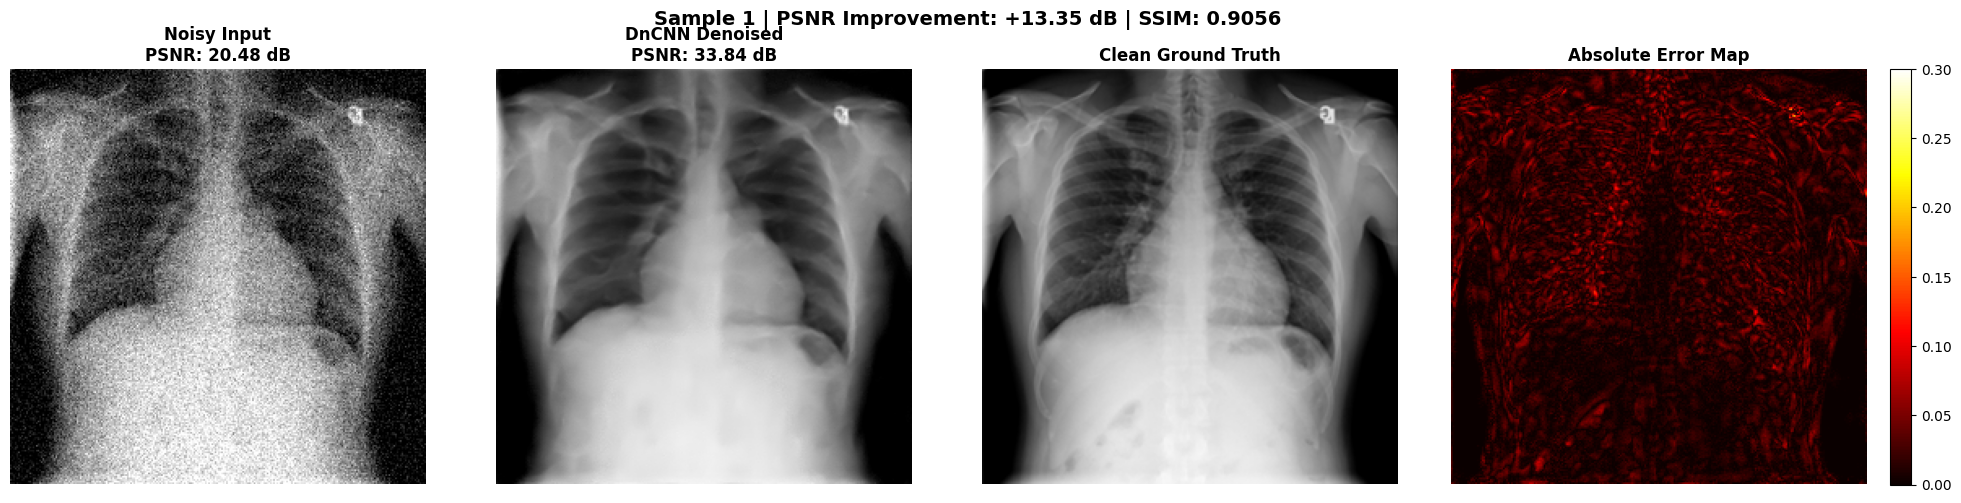

Sample 1 Metrics:
  Noisy PSNR:       20.48 dB
  Denoised PSNR:    33.84 dB
  Improvement:      +13.35 dB ⬆
  SSIM:             0.9056
------------------------------------------------------------


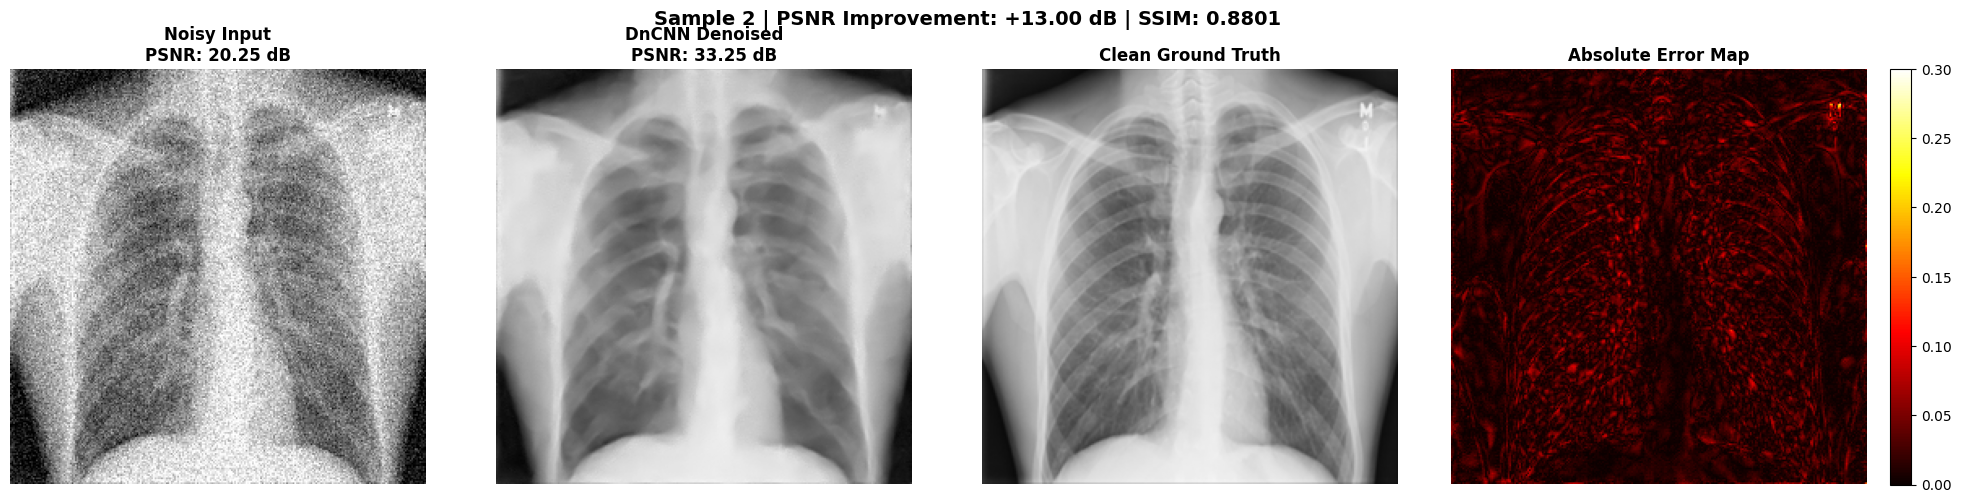

Sample 2 Metrics:
  Noisy PSNR:       20.25 dB
  Denoised PSNR:    33.25 dB
  Improvement:      +13.00 dB ⬆
  SSIM:             0.8801
------------------------------------------------------------


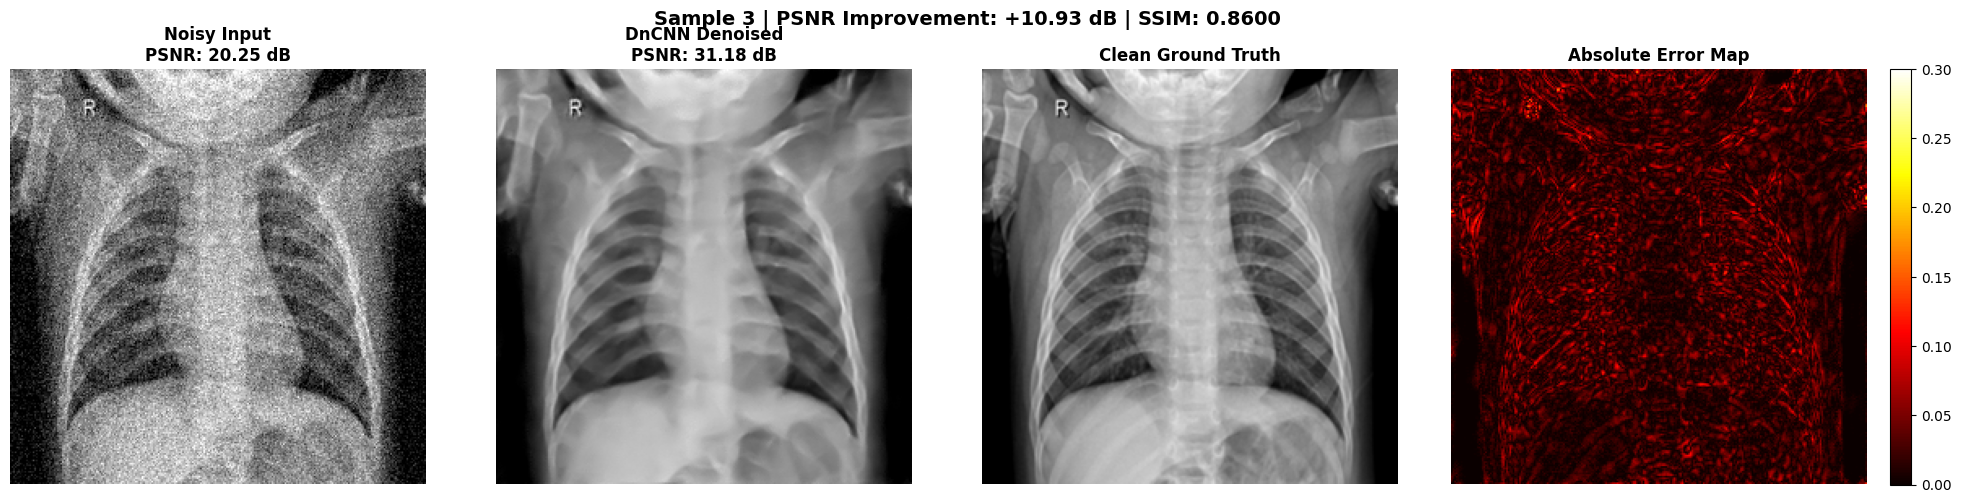

Sample 3 Metrics:
  Noisy PSNR:       20.25 dB
  Denoised PSNR:    31.18 dB
  Improvement:      +10.93 dB ⬆
  SSIM:             0.8600
------------------------------------------------------------

✓ INFERENCE COMPLETE!

Your DnCNN model successfully denoises X-ray images!
Check the visualizations above to see:
  • Noisy input images
  • DnCNN denoised output
  • Clean ground truth
  • Error maps showing residual noise


In [13]:
# ============================================================================
# INFERENCE: Test the trained DnCNN model
# ============================================================================

def test_on_random_samples(model, val_loader, device, num_samples=3):
    """Test the model and display results with metrics"""
    model.eval()

    # Get a batch
    batch = next(iter(val_loader))
    clean = batch['clean'].to(device)
    noisy = batch['noisy'].to(device)

    # Denoise
    with torch.no_grad():
        predicted_noise = model(noisy)
        denoised = noisy - predicted_noise

    # Convert to numpy and denormalize
    clean_np = (clean.cpu().numpy() * 0.5 + 0.5).clip(0, 1)
    noisy_np = (noisy.cpu().numpy() * 0.5 + 0.5).clip(0, 1)
    denoised_np = (denoised.cpu().numpy() * 0.5 + 0.5).clip(0, 1)

    # Display results
    num_to_show = min(num_samples, clean_np.shape[0])

    for i in range(num_to_show):
        # Calculate metrics
        img_psnr = psnr(clean_np[i, 0], denoised_np[i, 0], data_range=1.0)
        img_ssim = ssim(clean_np[i, 0], denoised_np[i, 0], data_range=1.0)
        noisy_psnr = psnr(clean_np[i, 0], noisy_np[i, 0], data_range=1.0)

        # Create figure
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        # Noisy
        axes[0].imshow(noisy_np[i, 0], cmap='gray', vmin=0, vmax=1)
        axes[0].set_title(f'Noisy Input\nPSNR: {noisy_psnr:.2f} dB',
                         fontsize=12, fontweight='bold')
        axes[0].axis('off')

        # Denoised
        axes[1].imshow(denoised_np[i, 0], cmap='gray', vmin=0, vmax=1)
        axes[1].set_title(f'DnCNN Denoised\nPSNR: {img_psnr:.2f} dB',
                         fontsize=12, fontweight='bold')
        axes[1].axis('off')

        # Clean
        axes[2].imshow(clean_np[i, 0], cmap='gray', vmin=0, vmax=1)
        axes[2].set_title('Clean Ground Truth', fontsize=12, fontweight='bold')
        axes[2].axis('off')

        # Difference map
        diff = np.abs(clean_np[i, 0] - denoised_np[i, 0])
        im = axes[3].imshow(diff, cmap='hot', vmin=0, vmax=0.3)
        axes[3].set_title('Absolute Error Map', fontsize=12, fontweight='bold')
        axes[3].axis('off')
        plt.colorbar(im, ax=axes[3], fraction=0.046)

        improvement = img_psnr - noisy_psnr
        plt.suptitle(f'Sample {i+1} | PSNR Improvement: +{improvement:.2f} dB | SSIM: {img_ssim:.4f}',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        print(f"Sample {i+1} Metrics:")
        print(f"  Noisy PSNR:       {noisy_psnr:.2f} dB")
        print(f"  Denoised PSNR:    {img_psnr:.2f} dB")
        print(f"  Improvement:      +{improvement:.2f} dB ⬆")
        print(f"  SSIM:             {img_ssim:.4f}")
        print("-" * 60)


# Run inference test
print("="*70)
print("TESTING TRAINED DnCNN MODEL")
print("="*70)
print(f"Model Performance: PSNR={checkpoint['val_psnr']:.2f} dB, SSIM={checkpoint['val_ssim']:.4f}")
print("="*70 + "\n")

test_on_random_samples(trained_model, val_loader, device, num_samples=3)

print("\n" + "="*70)
print("✓ INFERENCE COMPLETE!")
print("="*70)
print("\nYour DnCNN model successfully denoises X-ray images!")
print("Check the visualizations above to see:")
print("  • Noisy input images")
print("  • DnCNN denoised output")
print("  • Clean ground truth")
print("  • Error maps showing residual noise")

(1.0, 49.0)

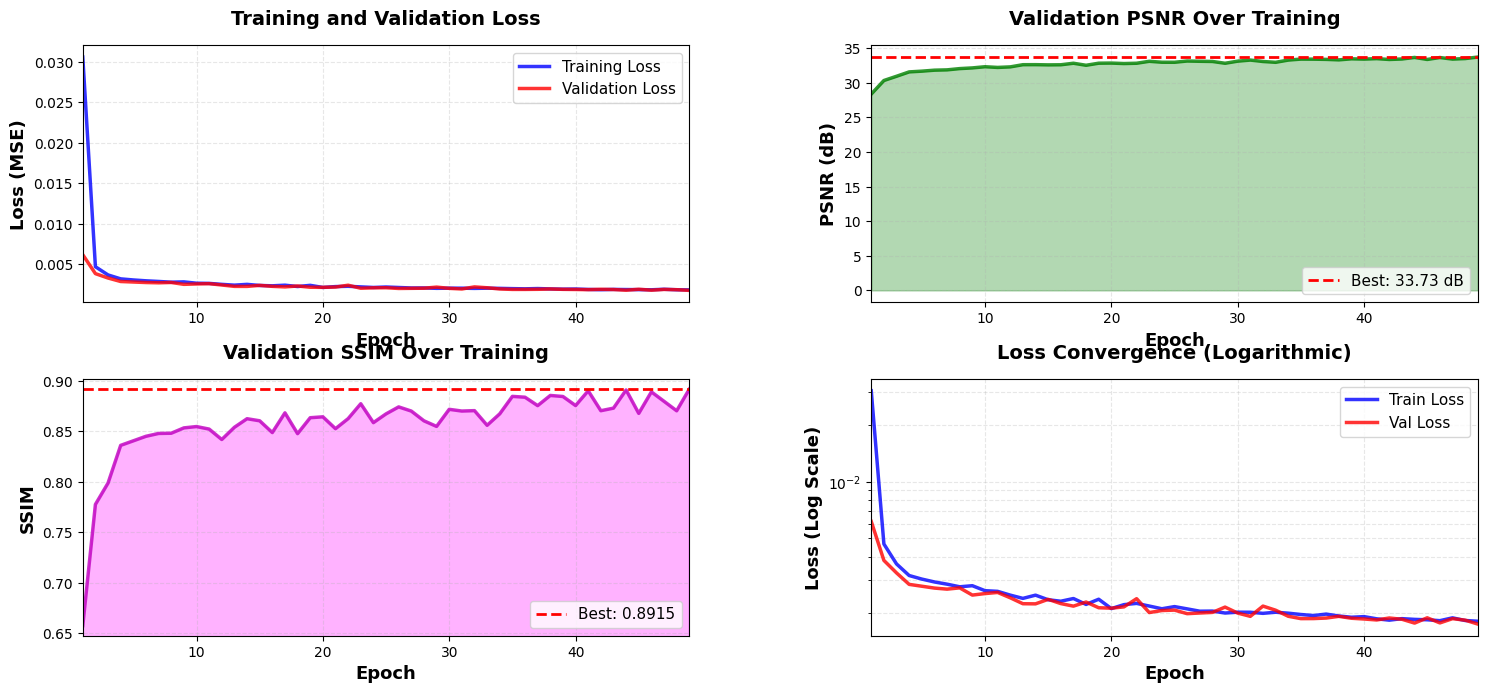

In [14]:
# ============================================================================
# COMPREHENSIVE TRAINING CURVES FOR RESULTS SECTION
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np

# Load the training history from checkpoint
checkpoint = torch.load(os.path.join(output_dir, 'dncnn_best.pth'), weights_only=False)
history = checkpoint['history']

fig = plt.figure(figsize=(18, 12))

# Create a 3x2 grid
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Training and Validation Loss
ax1 = fig.add_subplot(gs[0, 0])
epochs = range(1, len(history['train_loss']) + 1)
ax1.plot(epochs, history['train_loss'], 'b-', linewidth=2.5, label='Training Loss', alpha=0.8)
ax1.plot(epochs, history['val_loss'], 'r-', linewidth=2.5, label='Validation Loss', alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax1.set_ylabel('Loss (MSE)', fontsize=13, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xlim([1, len(epochs)])

# 2. Validation PSNR
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(epochs, history['val_psnr'], 'g-', linewidth=2.5, alpha=0.8)
ax2.axhline(y=max(history['val_psnr']), color='r', linestyle='--',
            linewidth=2, label=f"Best: {max(history['val_psnr']):.2f} dB")
ax2.fill_between(epochs, history['val_psnr'], alpha=0.3, color='green')
ax2.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax2.set_ylabel('PSNR (dB)', fontsize=13, fontweight='bold')
ax2.set_title('Validation PSNR Over Training', fontsize=14, fontweight='bold', pad=15)
ax2.legend(fontsize=11, loc='lower right')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xlim([1, len(epochs)])

# 3. Validation SSIM
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(epochs, history['val_ssim'], 'm-', linewidth=2.5, alpha=0.8)
ax3.axhline(y=max(history['val_ssim']), color='r', linestyle='--',
            linewidth=2, label=f"Best: {max(history['val_ssim']):.4f}")
ax3.fill_between(epochs, history['val_ssim'], alpha=0.3, color='magenta')
ax3.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax3.set_ylabel('SSIM', fontsize=13, fontweight='bold')
ax3.set_title('Validation SSIM Over Training', fontsize=14, fontweight='bold', pad=15)
ax3.legend(fontsize=11, loc='lower right')
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.set_xlim([1, len(epochs)])
ax3.set_ylim([min(history['val_ssim'])-0.01, max(history['val_ssim'])+0.01])

# 4. Loss Convergence (Log Scale)
ax4 = fig.add_subplot(gs[1, 1])
ax4.semilogy(epochs, history['train_loss'], 'b-', linewidth=2.5, label='Train Loss', alpha=0.8)
ax4.semilogy(epochs, history['val_loss'], 'r-', linewidth=2.5, label='Val Loss', alpha=0.8)
ax4.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax4.set_ylabel('Loss (Log Scale)', fontsize=13, fontweight='bold')
ax4.set_title('Loss Convergence (Logarithmic)', fontsize=14, fontweight='bold', pad=15)
ax4.legend(fontsize=11, loc='upper right')
ax4.grid(True, alpha=0.3, linestyle='--', which='both')
ax4.set_xlim([1, len(epochs)])